# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [ ]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

In [ ]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [ ]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [ ]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [ ]:
# 1.4)
import google.colab
from google.colab import files

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [ ]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 178kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.32MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.6MB/s]


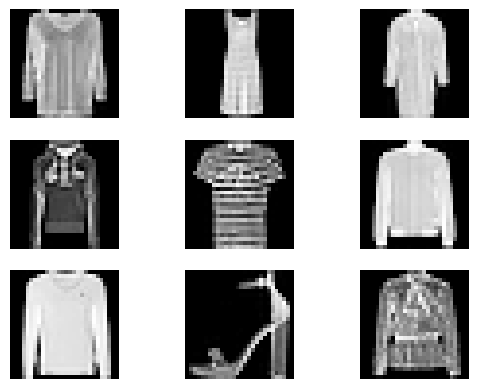

In [ ]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    #plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [ ]:
# 3.1)
# Creamos una subclase de la clase Dataset que nos sirva para generar lotes de ejemplos que puedan usarse para entrenar un autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = image #torch.flatten(image) # retornamos la imagen como salida
        return input,output

In [ ]:
# 3.2)
# Convertimos FashionMNIST Dataset a CustomDataset
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

## Ejercicio 4) Red Neuronal Autoencoder Convolucional

**1)** Defina y cree una red neuronal *autoencoder convolucional* constituida por las siguientes capas:


1. Capa convolucional 2D (encoder) compuesta por:

  * Una capa `Conv2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) que mapea una entrada con $1$ canal y dimensiones $(28,28)$ a una salida con $16$ canales y dimensiones $(26,26)$.
    Utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
  * Una capa `ReLU`.
  * Una capa `MaxPool2d` con un kernel de dimensiones $(2,2)$, de modo que la salida resultante tenga dimensiones $(16,13,13)$.
  * Una capa `Dropout` con probabilidad $p$.

2. Capa lineal (cuello de botella o “bottleneck”) compuesta por:

  * Una capa `Flatten` que transforma una entrada de dimensiones $(16,13,13)$ en un vector de dimensión $16\times 13\times 13 = 2704$.
  * Una capa `Linear` que mapea el vector de dimensión $2704$ a un vector de dimensión $n$ (donde $n$ es un número mucho menor, por ejemplo $n=128$, representando la *codificación comprimida* o *latente*).
  * Una capa `ReLU`.
  * Una capa `Linear` que mapea de nuevo el vector de dimensión $n$ al espacio original de dimensión $2704$.
  * Una capa `ReLU`.

3. Capa convolucional 2D transpuesta (decoder) compuesta por:

  * Una capa `Unflatten` que mapea el vector de dimensión $2704$ a una representación de $16$ canales con dimensiones $(13,13)$.
  * Una capa `ConvTranspose2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Utilice un kernel de dimensiones $(6,6)$, un stride de $(2,2)$, y un padding de $(1,1)$.
  * Una capa `Sigmoid`, para asegurar que las salidas se encuentren en el rango $[0,1]$ (asumiendo que las imágenes originales también fueron normalizadas en dicho rango).

**2)** Grafique, a modo de comparación, algunas imágenes de entrada y sus correspondientes reconstrucciones obtenidas con el modelo **sin entrenar** y con una probabilidad de *dropout* $p=0.2$.

In [ ]:
# 4.1)

## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [ ]:
# 5.1)